In [1]:
import numpy as np
import os, sys
current_dir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.insert(0, current_dir)
sys.path.insert(0, os.path.join(current_dir, 'conv_gp/'))
from conv_gp.models import ModelBuilder
from argparse import Namespace
import observations

import gpflow

In [2]:
model_path = './models/cifar_s211_M384.npy'
flags = Namespace(
    M='384,384,384',
    strides='2,1,1',
    feature_maps='10,10',
    filter_sizes='4,5,5',
    batch_size=64,
    base_kernel='rbf',
    last_kernel='conv',
    load_model=model_path,
    identity_mean=False,
    white=False,
    num_samples=5
)

In [3]:
(Xtrain, Ytrain), (Xtest, Ytest) = observations.cifar10('/tmp/cifar10')
Xtrain = np.transpose(Xtrain, [0, 2, 3, 1]).astype(np.float64)
Xtest = np.transpose(Xtest, [0, 2, 3, 1]).astype(np.float64)
Xtrain /= 255.0
Xtest /= 255.0

std = Xtrain.std(axis=(0, 1, 2))
mean = Xtrain.mean(axis=(0, 1, 2))
Xtrain -= mean
Xtrain /= std
Xtest -= mean
Xtest /= std

builder = ModelBuilder(flags, Xtrain, Ytrain, model_path=flags.load_model)
model = builder.build()

In [64]:
def test_accuracy_at_noise_level(noise_level, cut=False):
    temp_test = (Xtest * std) + mean
    corrupted_test = temp_test + np.random.randn(*Xtest.shape) * noise_level
    if cut:
        corrupted_test = np.where(np.less_equal(corrupted_test, 1.0), corrupted_test, np.ones_like(corrupted_test))
        corrupted_test = np.where(np.greater_equal(corrupted_test, 0.0), corrupted_test, np.zeros_like(corrupted_test))
  
    corrupted_test -= mean
    corrupted_test /= std
    
    correct = 0
    batch_size = 8
    import math
    batches = math.ceil(len(Ytest)/ batch_size)
    for i in range(batches):
        print("batch {}/{}".format(i, batches), end='\r')
        batch_slice = slice(i * batch_size, (i+1) * batch_size)
        X = corrupted_test[batch_slice] 
        X += np.random.randn(*X.shape) * noise_level
        Y = Ytest[batch_slice]
        X = X.reshape(X.shape[0], -1) 
        mean_predict, _ = model.predict_y(X, 25)
        class_probs = mean_predict.mean(axis=0)
        predicted = class_probs.argmax(axis=1)
        correct += (predicted == Y).sum()

    accuracy = correct / len(Ytest)
    print("accuracy: {}, noise_level: {}".format(accuracy, noise_level))

In [8]:
test_accuracy_at_noise_level(0.1)
test_accuracy_at_noise_level(0.25)
test_accuracy_at_noise_level(0.5)
test_accuracy_at_noise_level(1.0)

accuracy: 0.7607, noise_level: 0.0
accuracy: 0.5522, noise_level: 0.1
accuracy: 0.2215, noise_level: 0.25
accuracy: 0.1139, noise_level: 0.5
accuracy: 0.1019, noise_level: 1.0


In [9]:
test_accuracy_at_noise_level(0.1, True)
test_accuracy_at_noise_level(0.25, True)
test_accuracy_at_noise_level(0.5, True)
test_accuracy_at_noise_level(1.0, True)

accuracy: 0.5566, noise_level: 0.1
accuracy: 0.2217, noise_level: 0.25
accuracy: 0.1195, noise_level: 0.5
accuracy: 0.1004, noise_level: 1.0


In [4]:
saved_params = np.load(model_path).item()
sess = model.enquire_session()
model_params = {}
for param in model.parameters:
    saved = saved_params[param.pathname]
    value = sess.run(param.constrained_tensor)
    model_params[param.pathname] = value
    print(param.pathname, "diff ", np.linalg.norm(saved - value))

DGP/likelihood/likelihood/invlink/epsilon diff  0.0
DGP/layers/0/conv_kernel/base_kernel/variance diff  0.0
DGP/layers/0/conv_kernel/base_kernel/lengthscales diff  0.0
DGP/layers/0/conv_kernel/base_kernel/variance diff  0.0
DGP/layers/0/conv_kernel/base_kernel/lengthscales diff  0.0
DGP/layers/0/feature/Z diff  0.0
DGP/layers/0/q_mu diff  0.0
DGP/layers/0/q_sqrt diff  0.0
DGP/layers/1/conv_kernel/base_kernel/variance diff  0.0
DGP/layers/1/conv_kernel/base_kernel/lengthscales diff  0.0
DGP/layers/1/conv_kernel/base_kernel/variance diff  0.0
DGP/layers/1/conv_kernel/base_kernel/lengthscales diff  0.0
DGP/layers/1/feature/Z diff  0.0
DGP/layers/1/q_mu diff  0.0
DGP/layers/1/q_sqrt diff  0.0
DGP/layers/2/feature/Z diff  0.0
DGP/layers/2/kern/base_kernel/variance diff  0.0
DGP/layers/2/kern/base_kernel/lengthscales diff  0.0
DGP/layers/2/kern/patch_weights diff  0.0
DGP/layers/2/q_mu diff  0.0
DGP/layers/2/q_sqrt diff  0.0


In [9]:
Z = model.layers[0].feature.Z.value

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import umap
sns.set(style="ticks", palette="muted")
from kernels import _sample_patches
matplotlib.rc('figure', dpi=125)
matplotlib.rc('axes.spines', top=False)
matplotlib.rc('axes.spines', right=False)
matplotlib.rc('axes.spines', bottom=False)
matplotlib.rc('axes.spines', left=False)

matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
matplotlib.rc('axes', titlesize=16)
matplotlib.rc('axes', titlesize=16)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('axes', labelsize=16)
matplotlib.rc('axes', titlesize='x-large')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
font = {
    'size': 16,
    'family': 'sans-serif'
}
matplotlib.rc('font', **font)

In [10]:
def sample_patches(F, n_patches, patch_size=5, feature_maps=3):
    patch_length = patch_size**2 * feature_maps
    patches = np.zeros((n_patches, patch_length))
    for i in range(n_patches):
        random_image = F[np.random.choice(np.arange(F.shape[0]))]
        random_patch = _sample_patches(random_image, 1, patch_size, patch_length)
        patches[i, :] = random_patch
    return patches

patches = sample_patches(Xtrain, Z.shape[0], patch_size=4)
Z_and_patches = np.concatenate([patches, Z])

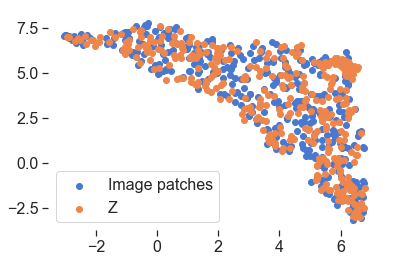

In [11]:
umap_object = umap.UMAP(n_components=2)
umap_object.fit(Z_and_patches)
embedded_Z = umap_object.transform(Z)
embedded_patches = umap_object.transform(patches)

plt.scatter(embedded_patches[:, 0], embedded_patches[:, 1], label="Image patches")
plt.scatter(embedded_Z[:, 0], embedded_Z[:, 1], label="Z")
plt.legend();

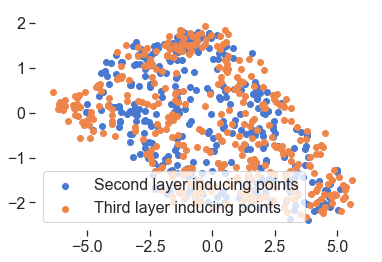

In [12]:
Z1 = model.layers[1].feature.Z.value
Z2 = model.layers[2].feature.Z.value
Z12 = np.concatenate([Z1, Z2], axis=0)

embedder = umap.UMAP(n_components=2)
embedder = embedder.fit(Z12)
Z1 = embedder.transform(Z1)
Z2 = embedder.transform(Z2)

plt.scatter(Z1[:, 0], Z1[:, 1], label="Second layer inducing points")
plt.scatter(Z2[:, 0], Z2[:, 1], label="Third layer inducing points")
plt.legend();

In [13]:
by_classes = np.stack([Xtrain[Ytrain==i][0:64] for i in range(10)])

In [14]:
layer1 = np.zeros((10, 64, 15, 15, 10))
layer2 = np.zeros((10, 64, 11, 11, 10))
layer3 = np.zeros((10, 64, 10))
sess = model.enquire_session()

for i in range(10):
    Fs, Fmeans, Fvars = model.propagate(by_classes[i, 0:64].reshape(64, -1), S=1)
    f = sess.run(Fs)
    layer1[i, :, :, :, :] = f[0].reshape(64, 15, 15, 10)
    layer2[i, :, :, :, :] = f[1].reshape(64, 11, 11, 10)
    layer3[i, :, :] = f[2].reshape(64, 10)


In [15]:
labels = (
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
    )
def plot_images(images, axis, title):
    embedder = umap.UMAP(n_components=2)
    dim = np.prod(images.shape[2:])
    embedder = embedder.fit(images.reshape(images.shape[1] * images.shape[0], dim))

    axis.set_title(title)
    [spine.set_visible(False) for spine in axis.spines.values()]
    for class_index in range(10):
        class_embedded = embedder.transform(images[class_index].reshape(64, dim))
        axis.scatter(class_embedded[:, 0], class_embedded[:, 1], label=labels[class_index])


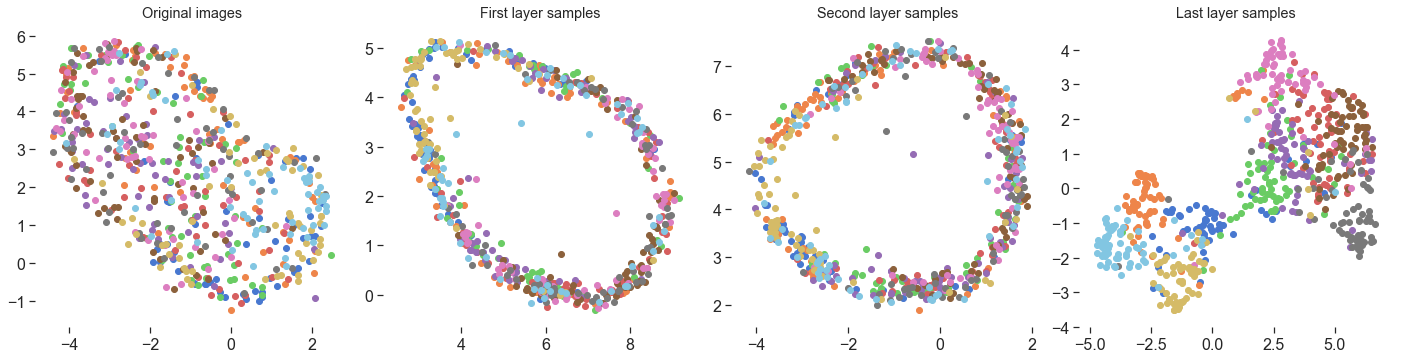

In [16]:

with sns.axes_style('ticks'):
    plt.figure(figsize=(4 * 4.8, 4.8))
    axis = plt.subplot2grid((1, 4), loc=(0, 0))
    plot_images(by_classes, axis, title='Original images')
    
    axis = plt.subplot2grid((1, 4), loc=(0, 1))
    plot_images(layer1, axis, title='First layer samples')
    
    axis = plt.subplot2grid((1, 4), loc=(0, 2))
    plot_images(layer2, axis, title='Second layer samples')
    
    axis = plt.subplot2grid((1, 4), loc=(0, 3))
    plot_images(layer3, axis, title='Last layer samples')
    plt.tight_layout(pad=0);

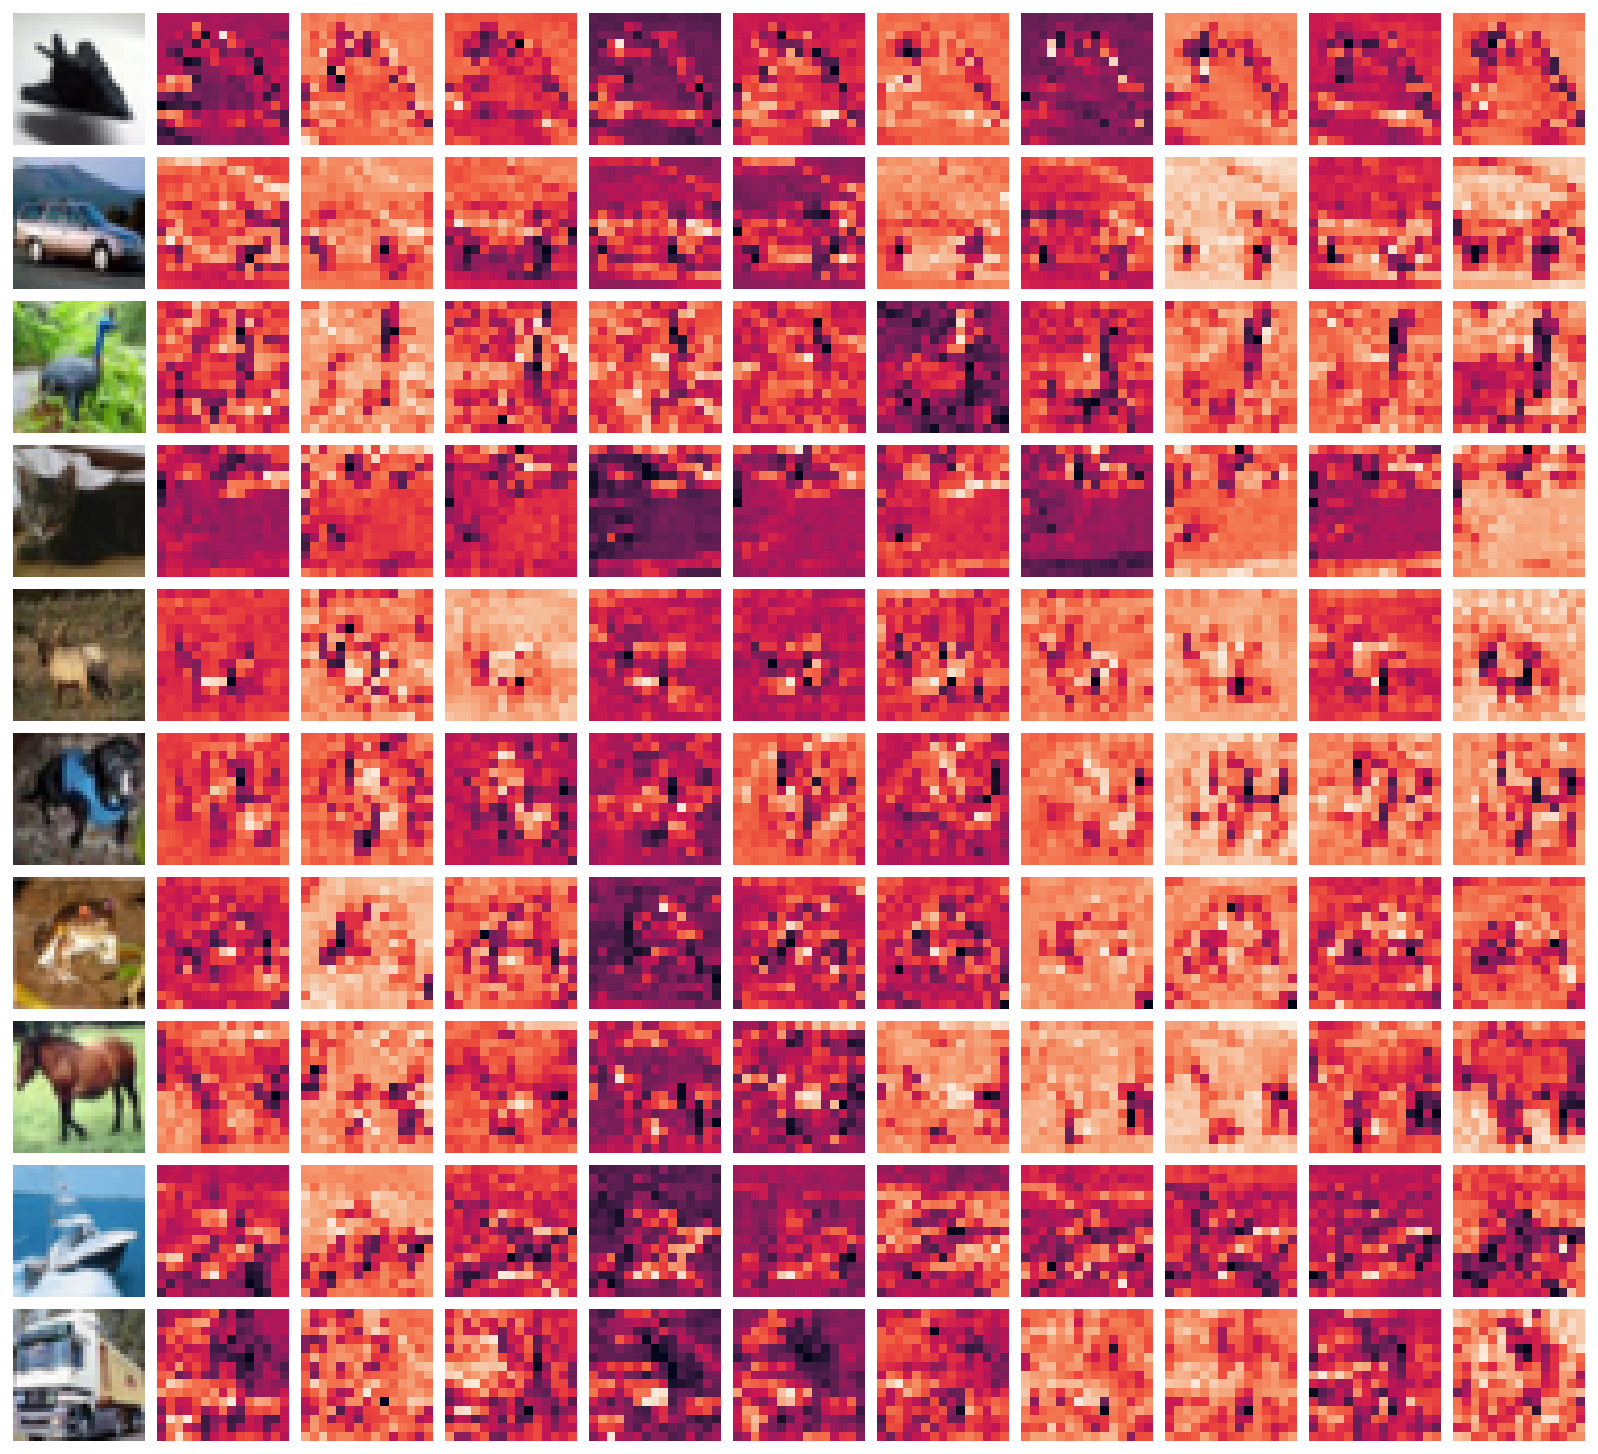

In [17]:
n_feature_maps = 10
figure = plt.figure(figsize=(11 * 2, 20))
for class_index in range(10):
    axis = plt.subplot2grid((10, 1 + n_feature_maps), loc=(class_index, 0))
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    [spine.set_visible(False) for spine in axis.spines.values()]
    image = by_classes[class_index, 0, :, :, :] * std + mean
    axis.imshow(image)
    
    for feature_map in range(0, n_feature_maps):
        axis = plt.subplot2grid((10, 1+ n_feature_maps), loc=(class_index, 1 + feature_map))
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        [spine.set_visible(False) for spine in axis.spines.values()]
        image = layer1[class_index, 0, :, :, feature_map]
        axis.imshow(image)
        
plt.tight_layout(pad=0);
# The "x-axis" of the grid represents different feature maps and the "y-axis" are activations over different classes.

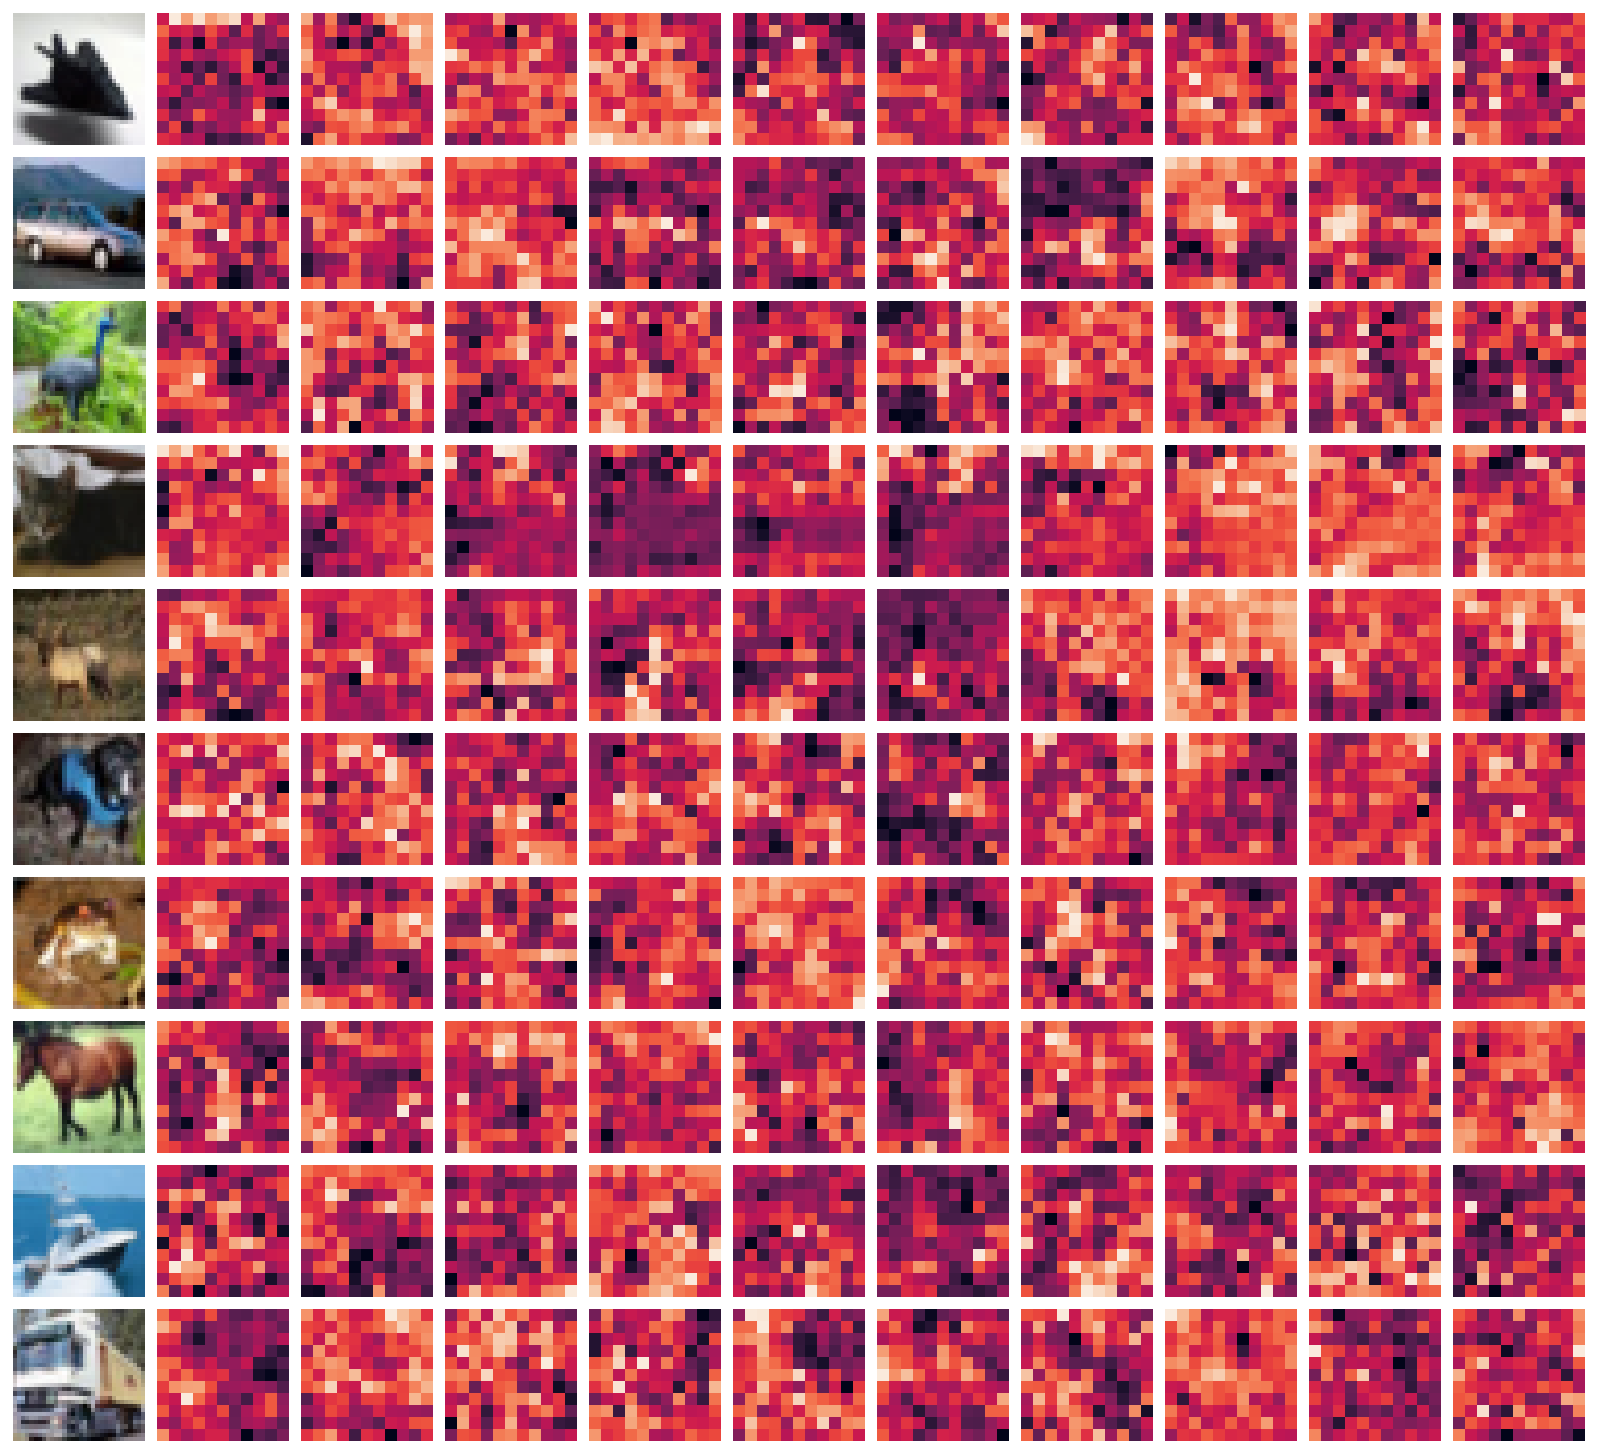

In [18]:
n_feature_maps = 10
figure = plt.figure(figsize=(11 * 2, 20))
for class_index in range(10):
    axis = plt.subplot2grid((10, 1 + n_feature_maps), loc=(class_index, 0))
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    [spine.set_visible(False) for spine in axis.spines.values()]
    image = by_classes[class_index, 0, :, :, :] * std + mean
    axis.imshow(image)
    for feature_map in range(0, n_feature_maps):
        axis = plt.subplot2grid((10, 1+ n_feature_maps), loc=(class_index, 1 + feature_map))
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        [spine.set_visible(False) for spine in axis.spines.values()]
        image = layer2[class_index, 0, :, :, feature_map]
        axis.imshow(image)
        
plt.tight_layout(pad=0);
# The "x-axis" of the grid represents different feature maps and the "y-axis" are activations over different classes.

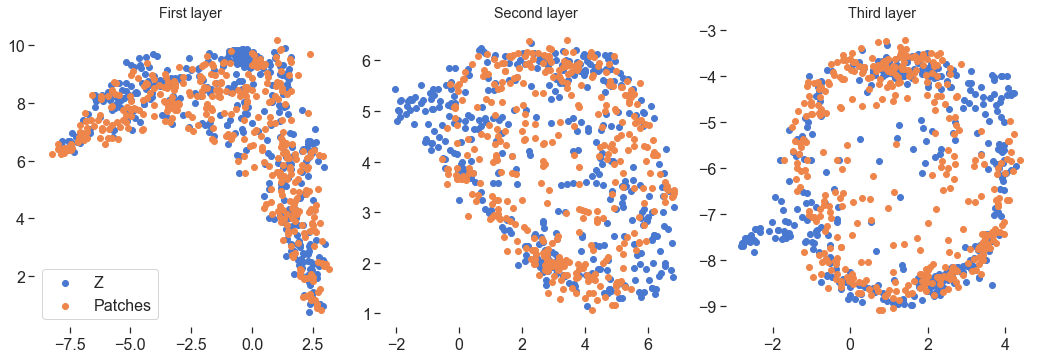

In [20]:
Z1 = model.layers[0].feature.Z.value
patches1 = sample_patches(Xtrain, Z1.shape[0], patch_size=4)

Z2 = model.layers[1].feature.Z.value
patches2 = sample_patches(layer1.reshape(-1, *layer1.shape[2:]), n_patches=Z2.shape[0], patch_size=5, feature_maps=10)

Z3 = model.layers[2].feature.Z.value
patches3 = sample_patches(layer2.reshape(-1, *layer2.shape[2:]), n_patches=Z3.shape[0], patch_size=5, feature_maps=10)

def embed(Z, P):
    umapper = umap.UMAP(n_components=2)
    Z_and_P = np.concatenate([Z, P], axis=0)
    umapper.fit(Z_and_P)
    return umapper.transform(Z), umapper.transform(P)

with sns.axes_style('ticks'):
    figure = plt.figure(figsize=(3 * 4.8, 4.8))
    axis = plt.subplot2grid((1, 3), loc=(0, 0))
    axis.set_title("First layer")
    Z, P = embed(Z1, patches1)
    Z_line = axis.scatter(Z[:, 0], Z[:, 1])
    P_line = axis.scatter(P[:, 0], P[:, 1])
    axis.legend((Z_line, P_line), ("Z", "Patches"))
    [s.set_visible(False) for s in axis.spines.values()]
    

    axis = plt.subplot2grid((1, 3), loc=(0, 1))
    axis.set_title("Second layer")
    Z, P = embed(Z2, patches2)
    axis.scatter(Z[:, 0], Z[:, 1])
    axis.scatter(P[:, 0], P[:, 1])
    [s.set_visible(False) for s in axis.spines.values()]
    
    axis = plt.subplot2grid((1, 3), loc=(0, 2))
    axis.set_title("Third layer")
    Z, P = embed(Z3, patches3)
    axis.scatter(Z[:, 0], Z[:, 1])
    axis.scatter(P[:, 0], P[:, 1]);
    [s.set_visible(False) for s in axis.spines.values()]
    

plt.tight_layout(pad=0)

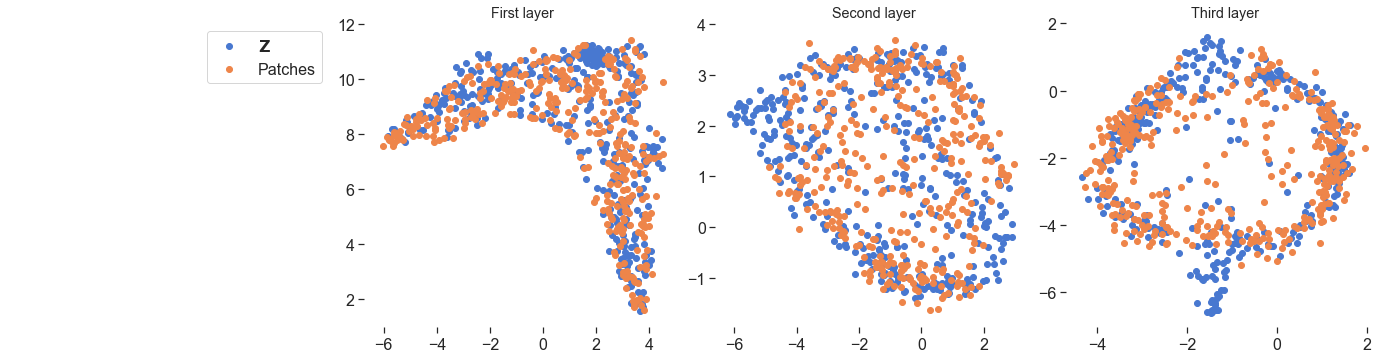

In [21]:

with sns.axes_style('ticks'):
    figsize = (4 * 4.8, 4.8)
    fig, axes = plt.subplots(figsize=figsize , nrows=1, ncols=4)
    
    axis = axes[1]
    axis.set_title("First layer")
    Z, P = embed(Z1, patches1)
    Z_line = axis.scatter(Z[:, 0], Z[:, 1])
    P_line = axis.scatter(P[:, 0], P[:, 1])
    [s.set_visible(False) for s in axis.spines.values()]
    

    axis = axes[2]
    axis.set_title("Second layer")
    Z, P = embed(Z2, patches2)
    axis.scatter(Z[:, 0], Z[:, 1])
    axis.scatter(P[:, 0], P[:, 1])
    [s.set_visible(False) for s in axis.spines.values()]
    
    axis = axes[3]
    axis.set_title("Third layer")
    Z, P = embed(Z3, patches3)
    axis.scatter(Z[:, 0], Z[:, 1])
    axis.scatter(P[:, 0], P[:, 1]);
    [s.set_visible(False) for s in axis.spines.values()]
    
    axis = axes[0]
    axis.legend((Z_line, P_line), (r"$\mathbf{Z}$", "Patches"))
    [s.set_visible(False) for s in axis.spines.values()]
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    
    plt.tight_layout(pad=0, h_pad=1)

In [55]:
def plot_patches(Z, num_patches, num_channels, channel, patch_size, rows, columns):
    plt.figure(figsize=(rows * 1, columns * 1))
    for row in range(rows):
        for column in range(columns):            
            axis = plt.subplot2grid((rows, columns), loc=(row, column))
            patch = Z[row * columns + column, np.arange(0, Z.shape[1], num_channels) + channel]
            axis.imshow(patch.reshape(patch_size))
            axis.xaxis.set_visible(False)
            axis.yaxis.set_visible(False)
    
    plt.tight_layout(pad=0)

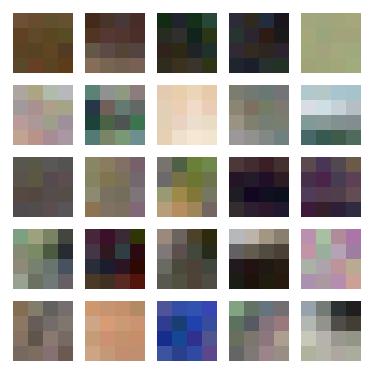

In [56]:
def plot_patches_color(Z, num_patches, num_channels, channel, patch_size, rows, columns):
    plt.figure(figsize=(rows * 1, columns * 1))
    zeros = np.zeros(patch_size + (3,))
    ones = np.ones(patch_size + (3,))
    for row in range(rows):
        for column in range(columns):            
            axis = plt.subplot2grid((rows, columns), loc=(row, column))
            patch = Z[row * columns + column, :]
            patch = patch.reshape(*patch_size, 3) * std + mean
            patch = np.maximum(np.minimum(patch, ones), zeros)
            axis.imshow(patch)
            axis.xaxis.set_visible(False)
            axis.yaxis.set_visible(False)
    
    plt.tight_layout(pad=0)
    
plot_patches_color(Z1, 384, 3, 0, (4, 4), rows=5, columns=5)

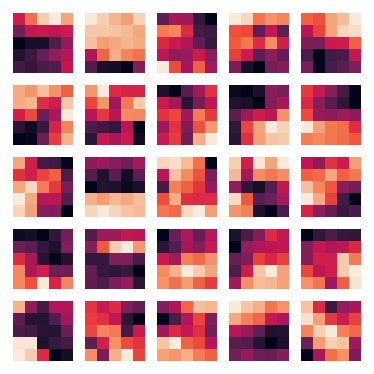

In [57]:
plot_patches(Z2, 384, 10, 0, (5, 5), 5, 5)

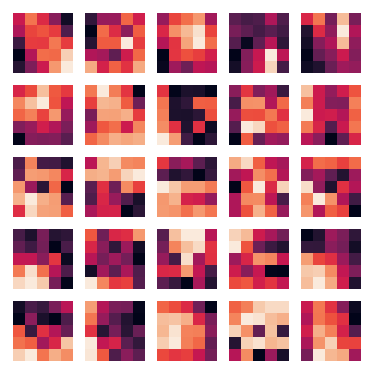

In [58]:
plot_patches(Z3, 384, 10, 0, (5, 5), 5, 5)